PREDICTING POTASSIUM - CLASSIFICATION SETUP

---



### 1. Google Colab runtime setup [Optional]

In [1]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

!pip install shap

Cloning into 'spectrai'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 290 (delta 91), reused 144 (delta 55), pack-reused 99
Receiving objects: 100% (290/290), 89.24 MiB | 31.06 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Checking out files: 100% (113/113), done.
Processing ./spectrai
     |████████████████████████████████| 20.0MB 1.2MB/s 
     |████████████████████████████████| 10.1MB 26.4MB/s 
     |████████████████████████████████| 6.8MB 43.1MB/s 
     |████████████████████████████████| 25.2MB 140kB/s 
     |████████████████████████████████| 225kB 54.8MB/s 
     |████████████████████████████████| 86.3MB 37kB/s 
     |████████████████████████████████| 112kB 56.6MB/s 
     |████████████████████████████████| 675kB 42.1MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 

     |████████████████████████████████| 327kB 5.2MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463905 sha256=a0f0afc0a4ba723975463a967a3c503052571a82fcc53b8459d58ffeb4ff13c6
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [3]:
# Create configuration file
# If exists: !rm -r  /root/.spectrai_config
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [4]:
# To train on a GPU
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 
     |████████████████████████████████| 10.6MB 55.9MB/s 
     |████████████████████████████████| 460kB 51.7MB/s 
ERROR: tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.0.0 has requirement tensorboard<2.1.0,>=2.0.0, but you'll have tensorboard 2.4.0 which is incompatible.
ERROR: tensorflow 2.0.0 has requirement tensorflow-estimator<2.1.0,>=2.0.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1


In [5]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, load_data)
from spectrai.vis.spectra import (plot_spectra)
from spectrai.features.preprocessing import (TakeDerivative, SNV, DropSpectralRegions)

import pandas as pd
import numpy as np

import seaborn as sns
#sns.set_theme(style="whitegrid")

import sklearn
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, log_loss, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import MinCovDet

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils

import tempfile
import os

from scipy import signal

import shap

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = (10, 8)


%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Utilities
def get_closest_wn(wns, wn):
    absolute_val_array = np.abs(X_names - wn)
    return X_names[absolute_val_array.argmin()]

def absorb(wavenumbers, gain=0.1, at=2001, spread=10):
    at = get_closest_wn(wavenumbers, at)
    t = np.linspace(-1, 1, len(wavenumbers), endpoint=False)
    i, _, e = signal.gausspulse(t, fc=len(wavenumbers)/spread, retquad=True, retenv=True)
    shift = np.argwhere(wavenumbers==at).item() - np.argmax(e)
    return gain*np.roll(e, shift)

def synthesize_data(X, y, absorbs, ratio=0.5):
    X_new = np.copy(X)
    y_new = np.zeros(len(y), dtype=int)
    nb_samples = int(ratio * X_new.shape[0])
    idx = np.random.choice(X_new.shape[0], size=nb_samples, replace=False)
    X_new[idx, :] +=  absorbs.reshape(1, -1)
    y_new[idx] = 1
    return (X_new, y_new)

# Custom Metrics
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    tp_ = tp(y_true, y_pred)
    fn_ = fn(y_true, y_pred)
    return tp_/(tp_+fn_)

def specificity(y_true, y_pred):
    tn_ = tn(y_true, y_pred)
    fp_ = fp(y_true, y_pred)
    return tn_/(tn_+fp_)

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn),
           'sensitivity': make_scorer(sensitivity), 'specificity': make_scorer(specificity), 'auc': 'roc_auc'} 

def log_loss(y_true, y_pred):
    return -(y_true*np.log10(y_pred)+(1-y_true)*np.log10(1-y_pred))

### 3. Load KSSL dataset

In [7]:
%%time
# K: 725, Carbonate: 54, Clay: 334
X, X_names, y, y_names, instances_id = load_data(725)

CPU times: user 22.7 s, sys: 4.47 s, total: 27.2 s
Wall time: 41.9 s


In [8]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)

print('Target variable: ', y_names)

X shape:  (50392, 1764)
X approx. memory size: 355 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


### 4. Plotting spectra

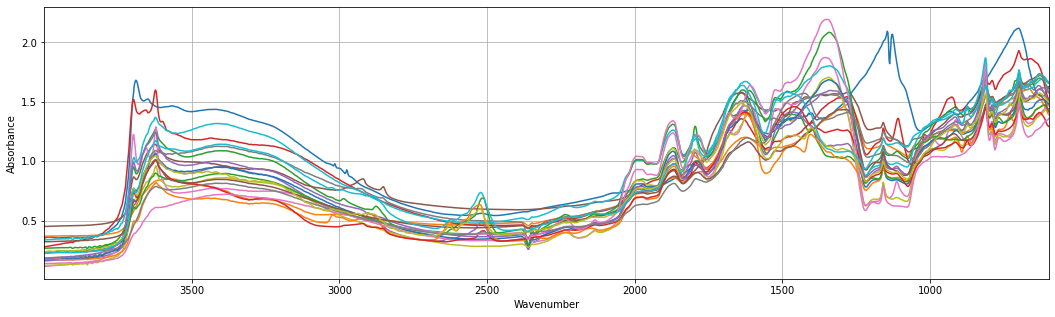

In [ ]:
# Quick plot of some spectra
plot_spectra(X, X_names, sample=20)

### 5. Exploratory Data Analysis and Cleaning

In [9]:
# Carbonate (54): 0.5, K (725): 0.12 as advised by USDA (Christopher Lee)
detection_limit = 0.12 

# How many samples above detection limit?
print('# samples > detection limit: {:.2f}%'.format(100 * sum(y[:, -1] >= detection_limit)/y.shape[0]))

# Select only value samples
valid_idx = y[:, -1] >= detection_limit
X_valid , y_valid, instances_id_valid =  X[valid_idx, :], y[valid_idx, :], instances_id[valid_idx]

# samples > detection limit: 80.01%


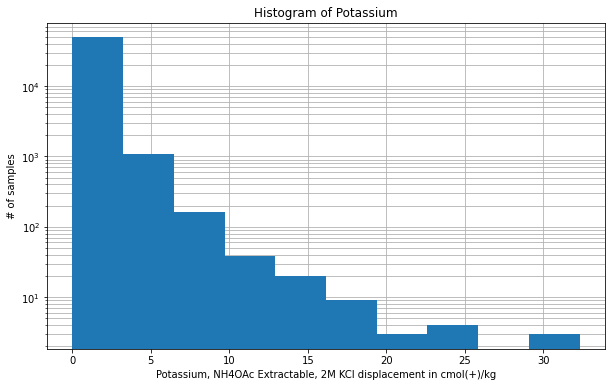

In [7]:
# Histogram of K
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Potassium, NH4OAc Extractable, 2M KCl displacement in cmol(+)/kg')
plt.ylabel('# of samples')
plt.title('Histogram of Potassium')
ax.grid(True, which='both')
ax.set_axisbelow(True)
ax.hist(y[:, -1], bins=10, log=True, histtype='bar', cumulative=False);

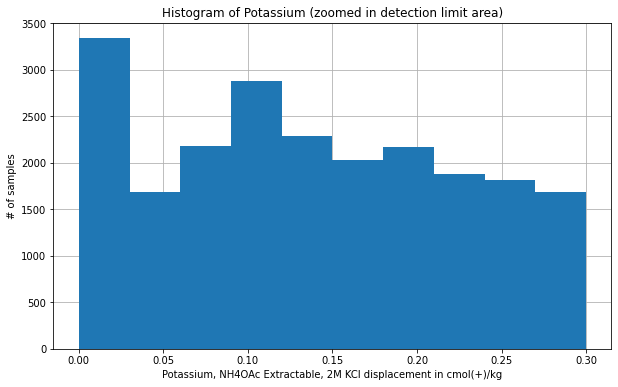

In [34]:
# Histogram of K zoomed
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Potassium, NH4OAc Extractable, 2M KCl displacement in cmol(+)/kg')
plt.ylabel('# of samples')
plt.title('Histogram of Potassium (zoomed in detection limit area)')
ax.grid(True, which='both')
ax.set_axisbelow(True)
ax.hist(y[(y[:, -1] <= 0.3), -1], log=False, histtype='bar', cumulative=False);

In [ ]:
# Some summary Statistics
np.percentile(y[:, -1], [25, 50, 75, 99.9])

array([ 9.53649395, 20.748492  , 32.36147858, 84.96237345])

* **Visualizing spectrum in PCA space**

In [ ]:
# Define the PCA object
n_components = 20
pca = PCA(n_components=n_components)

T = pca.fit_transform(TakeDerivative().fit_transform(SNV().fit_transform(X_valid)))

In [ ]:
def plot_explained_variance(pca, title='', figsize=(12, 6)):
    n_components = len(pca.explained_variance_ratio_)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    accent_color = 'firebrick'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    ax.set_ylabel('Explained variance')
    ax.set_xlabel('Nb. of PCA components')
    ax.grid(True, which='both')
    ax.set_xticks(range(1, n_components+1))
    ax.set_axisbelow(True)
    ax.bar(range(1, n_components+1), pca.explained_variance_ratio_, color='steelblue')
    
    ax_twin = ax.twinx()
    ax_twin.set_ylabel('Cumulated Explained Variance', color=accent_color)
    ax_twin.tick_params('y', colors=accent_color) 
    ax_twin.plot(range(1, n_components+1), cumsum, color=accent_color, lw=2)   

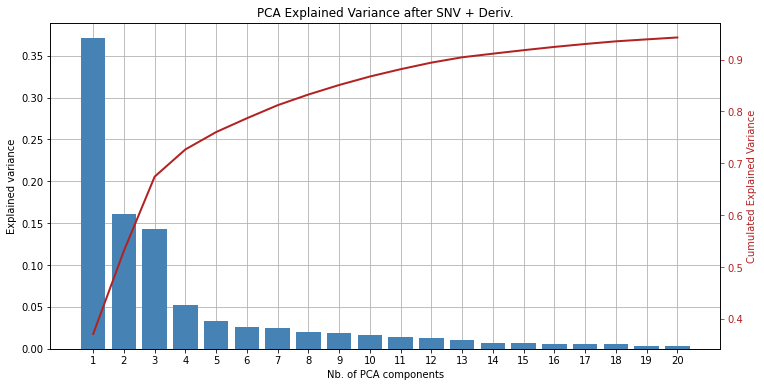

In [ ]:
plot_explained_variance(pca, 'PCA Explained Variance after SNV + Deriv.')

In [ ]:
nb_pc = 10
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(T[:, :nb_pc])
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:nb_pc])

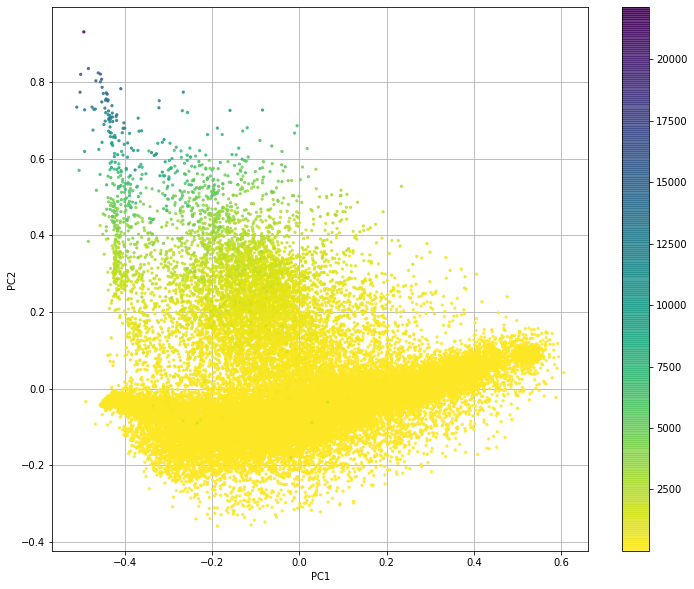

In [ ]:
# Score plot of the first 2 PC colored with Mahalanobis distance using the five first PCs
fig, ax = plt.subplots(figsize=(12, 10))
 
cpt_x, cpt_y = 0, 1
sc = ax.scatter(T[np.argsort(m), cpt_x], T[np.argsort(m), cpt_y], c=np.abs(np.sort(m)), cmap='viridis_r', edgecolors=None, s=5, alpha=0.8)
plt.xlabel('PC{}'.format(cpt_x+1))
plt.ylabel('PC{}'.format(cpt_y+1))
ax.set_axisbelow(True)
ax.grid(True, which='both')
plt.colorbar(sc);

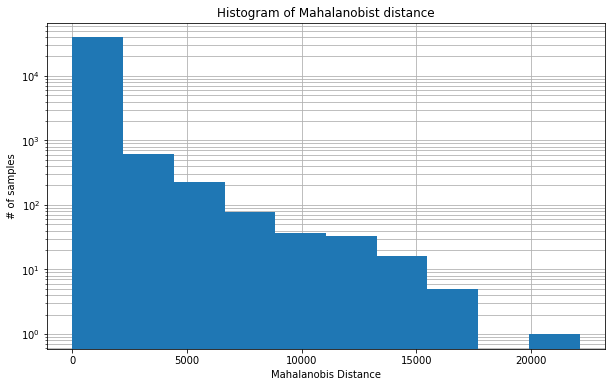

In [ ]:
# Histogram of Mahalanobis distance
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Mahalanobis Distance')
plt.ylabel('# of samples')
plt.title('Histogram of Mahalanobist distance')
ax.grid(True, which='both')
ax.set_axisbelow(True)
ax.hist(m, bins=10, log=True, histtype='bar', cumulative=False);

In [ ]:
np.percentile(m, 80)

92.73184622782705

In [ ]:
valid_idx = m < np.percentile(m, 80)
X_valid , y_valid, instances_id_valid =  X_valid[valid_idx, :], y_valid[valid_idx, :], instances_id_valid[valid_idx]

### 6. Predict

In [10]:
# Discretize based on domain knowledge (sensible low, high threshold): K: 1.062
threshold, low, high = 1.062, 0, 1
y_b = np.where(y_valid[:, -1] > threshold, high, low)

# Train, test split
X_train, X_test, y_train, y_test, smp_id_train, smp_id_test = train_test_split(X_valid, y_b, instances_id_valid,
                                                                               stratify=y_b, 
                                                                               test_size=0.2, 
                                                                               random_state=42)

neg, pos = np.bincount(y_b)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

Examples:
    Total: 40319
    Positive: 8106 (20.10% of total)

X_train shape:  (32255, 1764)
X_test shape:  (8064, 1764)


In [ ]:
# or Extreme discretization: partition in 3 quantiles and drop the central one
def X_classify(X, y):
    discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
    y_b = discretizer.fit_transform(y.reshape(-1, 1)).ravel()
    mask = np.logical_or(y_b==0, y_b==2)
    y_b = y_b[mask].astype('int')
    y_b[y_b==2] = 1
    print("Bin edges:", discretizer.bin_edges_)
    return (X[mask, :], y_b)

X_b, y_b = X_classify(X_valid, y_valid[:, -1])

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, stratify=y_b, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

Bin edges: [array([3.01218000e-02, 2.49297967e-01, 6.10461333e-01, 3.23309691e+01])]
X_train shape:  (25096, 1764)
X_test shape:  (6275, 1764)


X_train shape:  (40313, 1764)
X_test shape:  (10079, 1764)


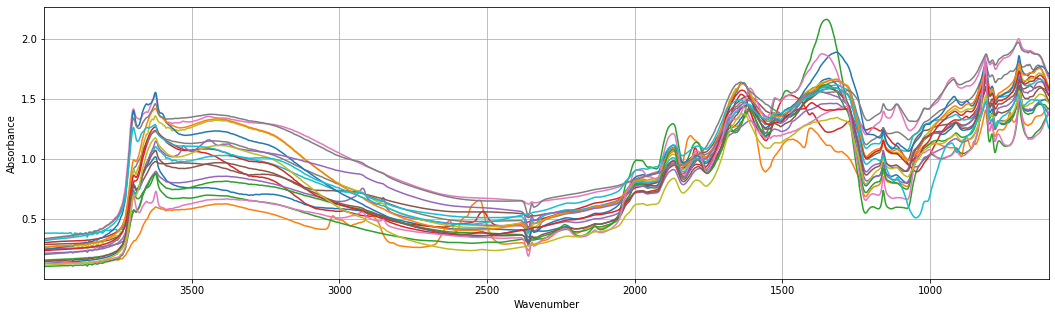

In [ ]:
# or synthetic dataset
X_synthesized, y_synthesized = synthesize_data(X, y[:, -1], absorb(X_names, gain=0.001, at=2750, spread=10))

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X_synthesized, y_synthesized, stratify=y_synthesized, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
plot_spectra(X_train, X_names, sample=20)

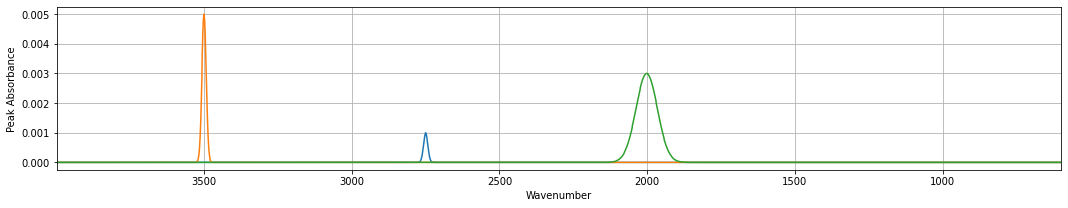

In [ ]:
# What does absorb do?
absorbs = []
for gain, at, spread in [(0.001, 2750, 10), (0.005, 3500, 10), (0.003, 2000, 50)]:
    absorbs.append(absorb(X_names, gain=gain, at=at, spread=spread))

fig, ax = plt.subplots(figsize=(18, 3))
ax.set_xlim(np.max(X_names), np.min(X_names))
ax.set(xlabel='Wavenumber', ylabel='Peak Absorbance')
ax.set_axisbelow(True)
ax.grid(True, which='both')
_ = ax.plot(X_names, np.array(absorbs).T)

#### Logistic Regression

In [47]:
# Hyperparameter grid
co2_region = [2389,  2269]

param_grid = {'model__C': [0.1, 0.5, 1, 5, 10]}
param_grid = {'model__C': [50]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='auto', penalty='l2'))])

# 'balanced_accuracy' is the arithmetic mean of recall and precision
grid_search = GridSearchCV(pipe, param_grid, cv=2, scoring=scoring, refit='auc', verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('snv', SNV()),
                                       ('derivative', TakeDerivative()),
                                       ('dropper',
                                        DropSpectralRegions(wavenumbers=array([3999, 3997, 3995, ...,  603,  601,  599], dtype=int32))),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000))]),
             param_grid={'model__C': [50]}, refit='auc',
             scoring={'auc': 'roc_auc', 'fn': make_scorer(fn),
                      'fp': make_scorer(fp),
                      'sensitivity': make_scorer(sensitivity),
                      'specificity': make_scorer(specificity),
                      'tn': make_scorer(tn), 'tp': make_scorer(tp)})

In [48]:
# Best score on valid. set
grid_search.best_score_

0.9066776683335002

In [49]:
# Score of best estimator on training set
grid_search.best_estimator_.score(X_train,y_train, sample_weight=y_train)

0.8548959136468774

In [50]:
# Score of best estimator on test set
grid_search.best_estimator_.score(X_test,y_test, sample_weight=y_test)

0.8562615669339914

In [52]:
def plot_along_wn(X, X_names, y_label='Absorbance', title='Weights', figsize=(22, 5)):   
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.xlabel('Wavenumber')
    plt.ylabel(y_label)
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.title(title)
    _ = ax.plot(X_names, X)

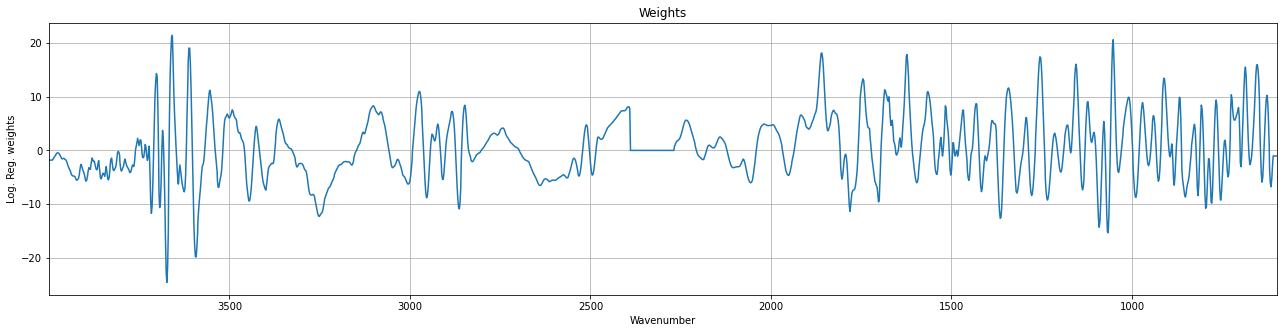

In [53]:
plot_along_wn(grid_search.best_estimator_['model'].coef_.ravel(), X_names, y_label='Log. Reg. weights')

In [54]:
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=5, method='decision_function')

In [55]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred, drop_intermediate=True)

In [56]:
def optimal_roc_cutoff(tpr, fpr, thresholds):
    probs = [to_prob(t) for t in thresholds]
    opt_idx = np.abs(tpr-(1-fpr)).argsort()[:1].item()
    return tpr[opt_idx], fpr[opt_idx], probs[opt_idx]

def to_prob(score):
    return 1/ (1 + np.exp(score))

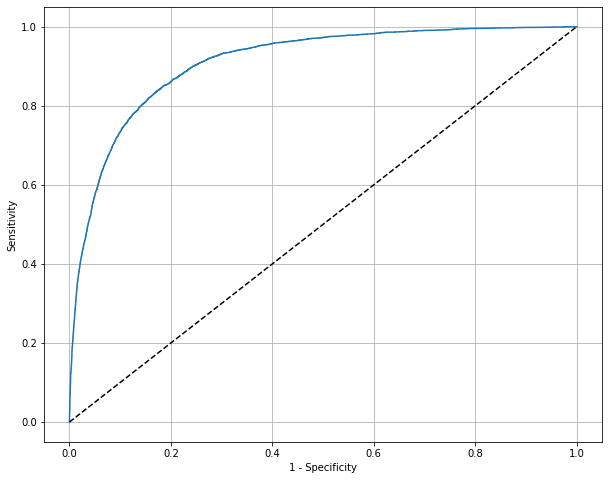

In [57]:
def plot_roc_curve(fpr, tpr, label=None, title=None, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.title(title)
    ax.plot(fpr, tpr, label=label)
    ax.plot([0, 1], [0, 1], 'k--') # dashed diagonal

plot_roc_curve(fpr, tpr)

In [58]:
opt_tpr, opt_fpr, opt_prob_threshold = optimal_roc_cutoff(tpr, fpr, thresholds)
print('Optimal probability threshold: {:.2f}'.format(opt_prob_threshold))

Optimal probability threshold: 0.47


In [59]:
roc_auc_score(y_train, y_train_pred)

0.909898583908599

#### XG-Boost

In [61]:
co2_region = [2389,  2269]

# Hyperparameter grid
#param_grid = {'model__eta': [0.05, 0.1, 0.3, 0.6], 'model__max_depth': [2, 4, 6, 8]}
param_grid = {'model__n_estimators': [2000]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=5, tree_method='gpu_hist'))])

grid_search = GridSearchCV(pipe, param_grid, cv=2, scoring=scoring, refit='auc', verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('snv', SNV()),
                                       ('derivative', TakeDerivative()),
                                       ('dropper',
                                        DropSpectralRegions(wavenumbers=array([3999, 3997, 3995, ...,  603,  601,  599], dtype=int32))),
                                       ('model',
                                        XGBClassifier(scale_pos_weight=5,
                                                      tree_method='gpu_hist'))]),
             param_grid={'model__n_estimators': [2000]}, refit='auc',
             scoring={'auc': 'roc_auc', 'fn': make_scorer(fn),
                      'fp': make_scorer(fp),
                      'sensitivity': make_scorer(sensitivity),
                      'specificity': make_scorer(specificity),
                      'tn': make_scorer(tn), 'tp': make_scorer(tp)})

In [62]:
grid_search.best_params_

{'model__n_estimators': 2000}

In [63]:
# Best score on valid. set
grid_search.best_score_

0.947876738951281

In [64]:
# Score of best estimator on training set
grid_search.best_estimator_.score(X_train,y_train, sample_weight=y_train)

1.0

In [65]:
# Score of best estimator on test set
grid_search.best_estimator_.score(X_test,y_test, sample_weight=y_test)

0.8309685379395435

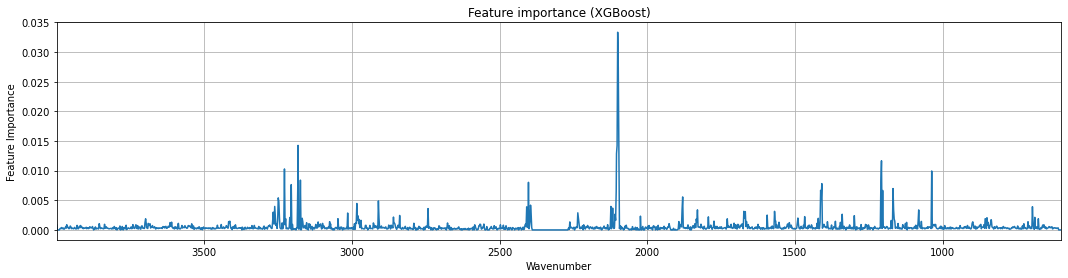

In [66]:
plot_along_wn(grid_search.best_estimator_['model'].feature_importances_, 
              X_names, y_label='Feature Importance', title='Feature importance (XGBoost)', figsize=(18, 4))

* **SHAP values**

In [ ]:
grid_search.best_estimator_['model']

XGBClassifier(n_estimators=2000, tree_method='gpu_hist')

In [ ]:
explainer = shap.TreeExplainer(grid_search.best_estimator_['model'])

* **Validation curve**

In [88]:
# Train, test split
#X_train, X_test, y_train, y_test, smp_id_train, smp_id_test = train_test_split(X_valid, y_b, instances_id_valid,
#                                                                               stratify=y_b, 
#                                                                               test_size=0.2, 
#                                                                               random_state=42)
#print('X_train shape: ', X_train.shape)
#print('X_test shape: ', X_test.shape)

# Additionnal Validation set for validation curve
X_train_vc, X_val_vc, y_train_vc, y_val_vc = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)
print('X_train shape: ', X_train_vc.shape)
print('X_validation shape: ', X_val_vc.shape)

X_train shape:  (25804, 1764)
X_validation shape:  (6451, 1764)


In [86]:
co2_region = [2389,  2269]

# Hyperparameter grid
#param_grid = {'model__eta': [0.05, 0.1, 0.3, 0.6], 'model__max_depth': [2, 4, 6, 8]}
param_grid = {'model__n_estimators': [2000]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=5, n_estimators=2000, tree_method='gpu_hist'))])

In [94]:
eval_set = [(X_train_vc, y_train_vc), (X_val_vc, y_val_vc)]
pipe.fit(X_train_vc, y_train_vc, model__eval_metric='auc', model__eval_set=eval_set, model__verbose=True)

[0]	validation_0-auc:0.499297	validation_1-auc:0.499224
[1]	validation_0-auc:0.499297	validation_1-auc:0.499224
[2]	validation_0-auc:0.499297	validation_1-auc:0.499224
[3]	validation_0-auc:0.499297	validation_1-auc:0.499224
[4]	validation_0-auc:0.499297	validation_1-auc:0.499224
[5]	validation_0-auc:0.499272	validation_1-auc:0.499127
[6]	validation_0-auc:0.499248	validation_1-auc:0.499127
[7]	validation_0-auc:0.499248	validation_1-auc:0.499127
[8]	validation_0-auc:0.499248	validation_1-auc:0.499127
[9]	validation_0-auc:0.499248	validation_1-auc:0.499127
[10]	validation_0-auc:0.499248	validation_1-auc:0.499127
[11]	validation_0-auc:0.499248	validation_1-auc:0.499127
[12]	validation_0-auc:0.499248	validation_1-auc:0.499127
[13]	validation_0-auc:0.499248	validation_1-auc:0.499127
[14]	validation_0-auc:0.499248	validation_1-auc:0.499127
[15]	validation_0-auc:0.499542	validation_1-auc:0.499612
[16]	validation_0-auc:0.49922	validation_1-auc:0.498642
[17]	validation_0-auc:0.500628	validation_

KeyboardInterrupt: ignored

In [81]:
def plot_xgboost_valid_curve(history, metric='auc', figsize=(10, 6)):
    epochs = len(history['validation_0'][metric])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=figsize)
    plt.xlabel('Epochs (n_estimators)')
    plt.ylabel(metric)
    plt.title('Validation Curve')
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    ax.plot(x_axis, history['validation_0'][metric], label='Train')
    ax.plot(x_axis, history['validation_1'][metric], label='Validation')
    ax.legend()

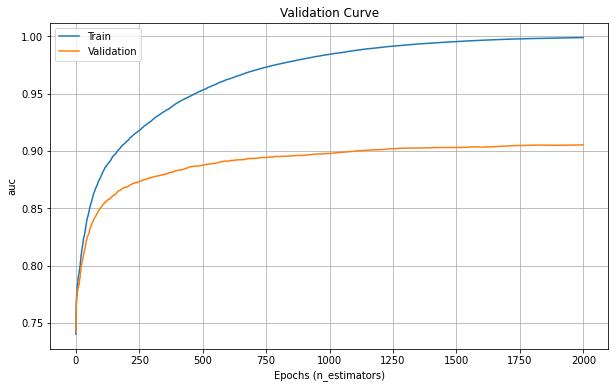

In [82]:
plot_xgboost_valid_curve(model.evals_result())

In [71]:
model.score(X_test,y_test, sample_weight=y_test)

0.5453423812461443

#### CNN

In [ ]:
# When XClassification
X_b, y_b = X_classify(X_valid, y_valid[:, -1])

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(SNV().fit_transform(X_b), y_b, stratify=y_b, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# Additionnal Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_validation shape: ', X_val.shape)

In [11]:
# Default case
# Train, test split
X_train, X_test, y_train, y_test, smp_id_train, smp_id_test = train_test_split(SNV().fit_transform(X_valid), y_b, instances_id_valid,
                                                                               stratify=y_b, 
                                                                               test_size=0.2, 
                                                                               random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# Additionnal Validation set
X_train, X_val, y_train, y_val, smp_id_train, smp_id_val = train_test_split(X_train, y_train, smp_id_train,
                                                                            stratify=y_train, 
                                                                            test_size=0.2, 
                                                                            random_state=42)
print('X_train shape: ', X_train.shape)
print('X_validation shape: ', X_val.shape)

X_train shape:  (32255, 1764)
X_test shape:  (8064, 1764)
X_train shape:  (25804, 1764)
X_validation shape:  (6451, 1764)


In [ ]:
# or synthetized dataset
X_synthesized, y_synthesized = synthesize_data(X, y[:, -1], absorb(X_names, gain=0.5, at=2750, spread=10))

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(SNV().fit_transform(X_synthesized), y_synthesized, 
                                                    stratify=y_synthesized, test_size=0.2, random_state=42)

# Additionnal Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [ ]:
# Checking classes imbalance
list(map(lambda y: 100*np.sum(y)/len(y), [y_train, y_val, y_test]))

[20.105410013951325, 20.105410013951325, 20.10168650793651]

##### Reproducing imbalanced dataset TF tutorial

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(input_dim=X_train.shape[1], metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Model "optimized" for K
    activation = 'relu'
    #num_classes = len(np.unique(y_train))

    model = keras.models.Sequential()
    model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

    model.add(layers.Conv1D(32, 30, activation=activation))
    model.add(layers.MaxPool1D(4))

    model.add(layers.Conv1D(64, 30, activation=activation))
    model.add(layers.MaxPool1D(4))

    model.add(layers.Conv1D(128, 30, activation=activation))
    model.add(layers.MaxPool1D(4))


    model.add(layers.Flatten())

    model.add(layers.Dense(100, activation=activation))
    model.add(layers.Dense(50, activation=activation))
    model.add(layers.Dense(10, activation=activation))
    model.add(layers.Dense(1,  activation='sigmoid', bias_initializer=output_bias))

    model.compile(optimizer=Adam(lr=1e-3), 
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
  
    return model

def make_model_alt(input_dim=X_train.shape[1], metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Model "optimized" for K
    activation = 'relu'
    #num_classes = len(np.unique(y_train))

    model = keras.models.Sequential()
    model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

    model.add(layers.Conv1D(32, 5, activation=activation))
    model.add(layers.MaxPool1D(4))

    model.add(layers.Conv1D(64, 5, activation=activation))
    model.add(layers.MaxPool1D(4))

    model.add(layers.Conv1D(128, 5, activation=activation))
    model.add(layers.MaxPool1D(4))


    model.add(layers.Flatten())

    model.add(layers.Dense(100, activation=activation))
    model.add(layers.Dense(50, activation=activation))
    model.add(layers.Dense(10, activation=activation))
    model.add(layers.Dense(1,  activation='sigmoid', bias_initializer=output_bias))

    model.compile(optimizer=Adam(lr=1e-3), 
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
  
    return model

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1764, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1735, 32)          992       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 433, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 404, 64)           61504     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 101, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 72, 128)           245888    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 128)           0

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# results return loss + metrics list
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4151


In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.37976557])

In [16]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

array([[0.20367514],
       [0.20328201],
       [0.20666657],
       [0.2035019 ],
       [0.20527217],
       [0.20382842],
       [0.20399167],
       [0.20488007],
       [0.20436206],
       [0.20488003]], dtype=float32)

In [17]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

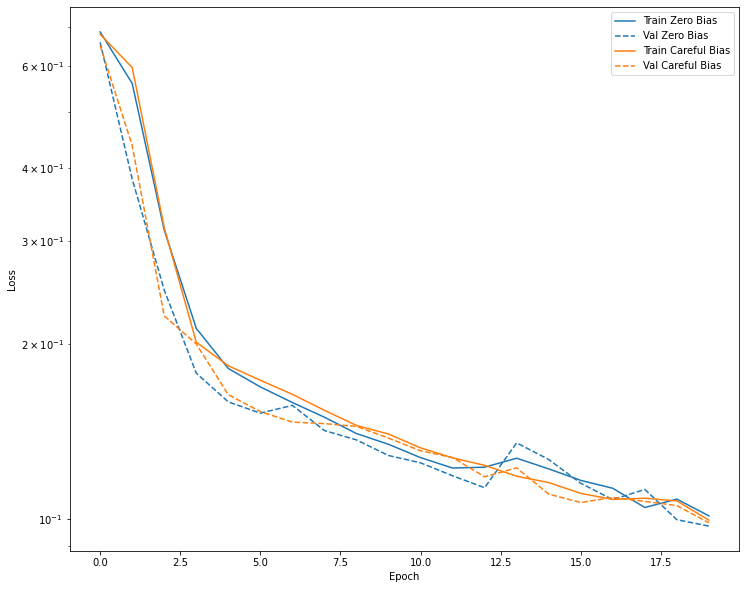

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [105]:
# Train the model
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - ETA: 0s - loss: 0.4766 - tp: 5318.0000 - fp: 20722.0000 - tn: 20510.0000 - fn: 5058.0000 - accuracy: 0.5005 - precision: 0.2042 - recall: 0.5125 - auc: 0.5547WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f0faaad7620> and will run it as-is.
Please report this

In [23]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

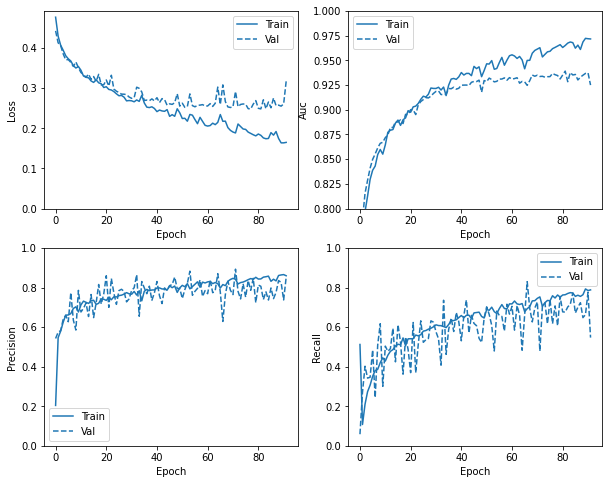

In [107]:
plot_metrics(baseline_history)

In [108]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [18]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Low/Medium predicted as Low/Medium (True Negatives): ', cm[0][0])
  print('Low/Medium predicted as High (False Positives): ', cm[0][1])
  print('High predicted as Low/Medium (False Negatives): ', cm[1][0])
  print('High predicted as High (True Positives): ', cm[1][1])
  #print('Total Positives Transactions: ', np.sum(cm[1]))

loss :  0.2556740939617157
tp :  1094.0
fp :  239.0
tn :  6204.0
fn :  527.0
accuracy :  0.905009925365448
precision :  0.8207051753997803
recall :  0.6748920679092407
auc :  0.9330095052719116

Legitimate Positives Detected (True Negatives):  6204
Legitimate Positives Incorrectly Detected (False Positives):  239
Fraudulent Positives Missed (False Negatives):  527
Fraudulent Positives Detected (True Positives):  1094
Total Positives Transactions:  1621


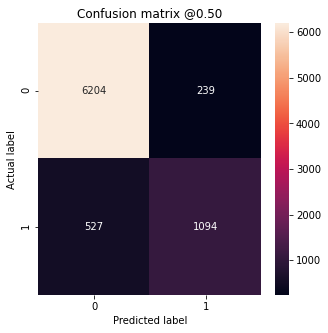

In [110]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,40])
  plt.ylim([60,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

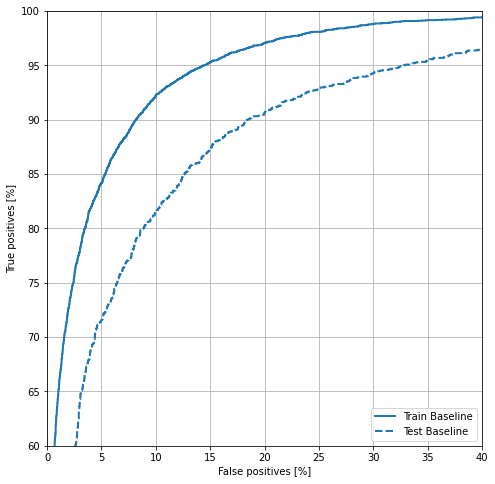

In [112]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [20]:
# Calculating class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.63
Weight for class 1: 2.49


In [21]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
13/13 [==============================] - 5s 362ms/step - loss: 0.7089 - tp: 7287.0000 - fp: 26894.0000 - tn: 14338.0000 - fn: 3089.0000 - accuracy: 0.4190 - precision: 0.2132 - recall: 0.7023 - auc: 0.5175 - val_loss: 0.6180 - val_tp: 815.0000 - val_fp: 1465.0000 - val_tn: 3689.0000 - val_fn: 482.0000 - val_accuracy: 0.6982 - val_precision: 0.3575 - val_recall: 0.6284 - val_auc: 0.7437
Epoch 2/100
13/13 [==============================] - 3s 259ms/step - loss: 0.6026 - tp: 3552.0000 - fp: 6897.0000 - tn: 13719.0000 - fn: 1636.0000 - accuracy: 0.6693 - precision: 0.3399 - recall: 0.6847 - auc: 0.7393 - val_loss: 0.7163 - val_tp: 1221.0000 - val_fp: 3012.0000 - val_tn: 2142.0000 - val_fn: 76.0000 - val_accuracy: 0.5213 - val_precision: 0.2884 - val_recall: 0.9414 - val_auc: 0.7894
Epoch 3/100
13/13 [==============================] - 3s 258ms/step - loss: 0.5678 - tp: 3995.0000 - fp: 7372.0000 - tn: 13244.0000 - fn: 1193.0000 - accuracy: 0.6681 - precision: 0.3515 - recall: 0.7

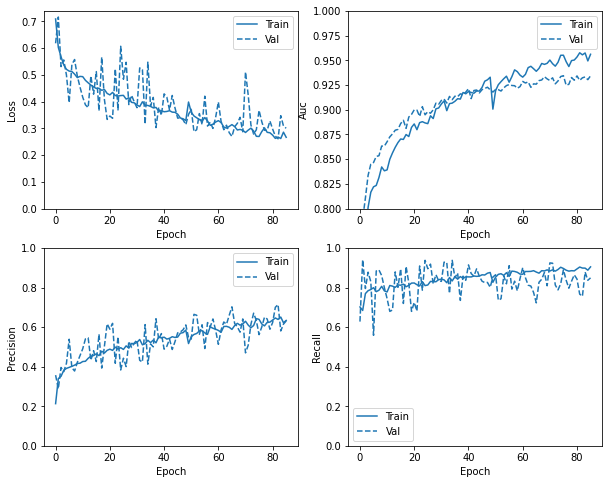

In [24]:
plot_metrics(weighted_history)

In [26]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.39204564690589905
tp :  1450.0
fp :  1223.0
tn :  5220.0
fn :  171.0
accuracy :  0.8271329402923584
precision :  0.542461633682251
recall :  0.8945095539093018
auc :  0.929531455039978

Low/Medium predicted as Low/Medium (True Negatives):  5220
Low/Medium predicted as High (False Positives):  1223
High predicted as Low/Medium (False Negatives):  171
High predicted as High (True Positives):  1450


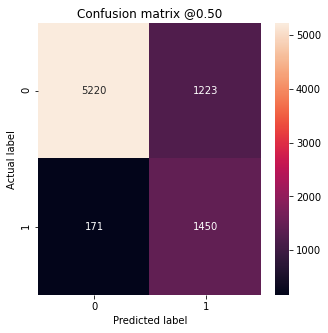

In [27]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

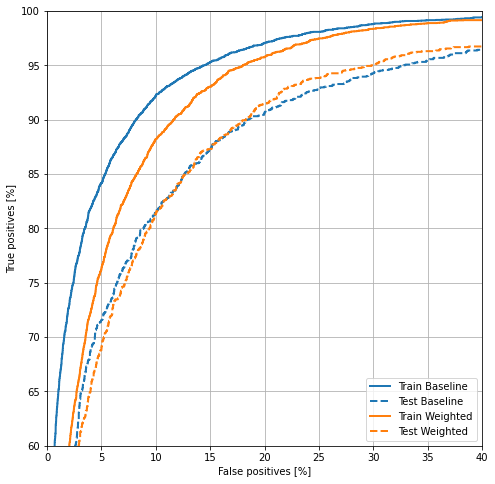

In [119]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

##### Legacy pipeline

In [ ]:
# Model "optimized" for K
activation = 'relu'
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32, 30, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, 30, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, 30, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.Dropout(rate=0.4))

model.add(layers.Flatten())

#model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation=activation))

#model.add(layers.BatchNormalization())
model.add(layers.Dense(50, activation=activation))

#model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation=activation))

#model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(num_classes,  activation='softmax'))

#model.compile(optimizer=Adam(learning_rate=1e-3), loss=keras.losses.categorical_crossentropy, metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives()])
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1764, 1)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1735, 32)          992       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 433, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 404, 64)           61504     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 101, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 72, 128)           245888    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 18, 128)          

In [ ]:
# Model hyperparameters tuning
activation = 'relu'
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32, 3, activation=activation))
model.add(layers.MaxPool1D(2))

#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, 10, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, 30, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.Dropout(rate=0.4))

model.add(layers.Flatten())

#model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation=activation))

#model.add(layers.BatchNormalization())
model.add(layers.Dense(50, activation=activation))

#model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation=activation))

#model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(num_classes,  activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-3), loss=keras.losses.categorical_crossentropy, metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives()])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1764, 1)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1762, 32)          128       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 881, 32)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 872, 64)           20544     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 218, 64)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 189, 128)          245888    
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 47, 128)          

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train)
y_val_cat = keras.utils.to_categorical(y_val)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-3)

In [ ]:
history = model.fit(X_train, y_train_cat, epochs=40, validation_data=(X_val, y_val_cat), callbacks=[reduce_lr])

Epoch 1/40
920/920 [==============================] - 7s 8ms/step - loss: 0.3086 - accuracy: 0.8568 - true_positives_1: 25207.0000 - true_negatives_1: 25207.0000 - val_loss: 0.2463 - val_accuracy: 0.8923 - val_true_positives_1: 6564.0000 - val_true_negatives_1: 6564.0000
Epoch 2/40
920/920 [==============================] - 7s 7ms/step - loss: 0.2349 - accuracy: 0.8995 - true_positives_1: 26464.0000 - true_negatives_1: 26464.0000 - val_loss: 0.2195 - val_accuracy: 0.9035 - val_true_positives_1: 6646.0000 - val_true_negatives_1: 6646.0000
Epoch 3/40
920/920 [==============================] - 7s 7ms/step - loss: 0.2137 - accuracy: 0.9096 - true_positives_1: 26759.0000 - true_negatives_1: 26759.0000 - val_loss: 0.2039 - val_accuracy: 0.9126 - val_true_positives_1: 6713.0000 - val_true_negatives_1: 6713.0000
Epoch 4/40
920/920 [==============================] - 7s 7ms/step - loss: 0.2045 - accuracy: 0.9132 - true_positives_1: 26865.0000 - true_negatives_1: 26865.0000 - val_loss: 0.1973 - v

In [ ]:
y_test_cat = keras.utils.to_categorical(y_test)

results = model.evaluate(X_test, y_test_cat, batch_size=128)
print("test loss, test acc:", results)

72/72 [==============================] - 1s 8ms/step - loss: 0.1419 - accuracy: 0.9471 - true_positives_1: 8708.0000 - true_negatives_1: 8708.0000
test loss, test acc: [0.14193633198738098, 0.9471394419670105, 8708.0, 8708.0]


In [ ]:
MODEL_PATH = './cnn-100-epochs-snv.h5'
model.save(MODEL_PATH)

##### Shap values

In [28]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
smp_size = 100
e = shap.DeepExplainer(weighted_model, background)
# ...or pass tensors directly
#shap_values = e.shap_values(X_test[1:smp_size])

keras is no longer supported, please use tf.keras instead.


In [29]:
mask_pos = (weighted_model.predict(X_test) > 0.5).ravel()
loss = log_loss(y_test, weighted_model.predict(X_test).ravel())

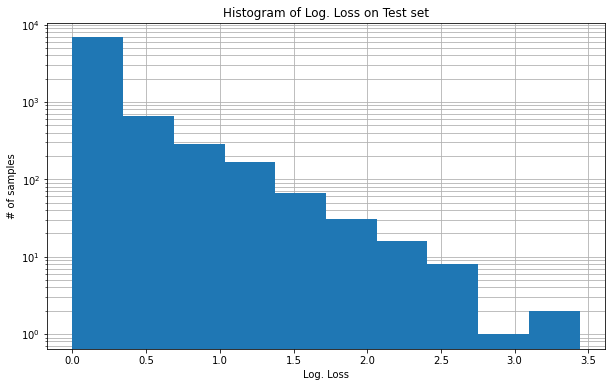

In [30]:
# Histogram of log loss
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Log. Loss')
plt.ylabel('# of samples')
plt.title('Histogram of Log. Loss on Test set')
ax.grid(True, which='both')
ax.set_axisbelow(True)
ax.hist(loss, bins=10, log=True, histtype='bar', cumulative=False);

In [209]:
np.percentile(loss, [5, 10, 25, 50, 75, 99.9])

array([1.06943933e-03, 2.30263984e-03, 6.22817059e-03, 2.48364788e-02,
       1.44043006e-01, 2.09031606e+00])

In [31]:
def plot_shap_values(X_test, X_names, title='', figsize=(18,10)):
    shap_values = e.shap_values(X_test)
    print(title)
    print('Number of samples: ', shap_values[0].shape[0])
    fig, ax = plt.subplots(2, figsize=(18, 10))
    ax[0].set_xlim(np.max(X_names), np.min(X_names))
    ax[0].set(xlabel='Wavenumber', ylabel='SHAP value')
    ax[0].set_axisbelow(True)
    ax[0].grid(True, which='both')
    _ = ax[0].plot(X_names, shap_values[0].T, c='steelblue', alpha=0.2)

    # Positive and low loss [SPECTRUM]
    #fig, ax = plt.subplots(figsize=(18, 5))
    ax[1].set_xlim(np.max(X_names), np.min(X_names))
    ax[1].set(xlabel='Wavenumber', ylabel='Absorbance')
    ax[1].set_axisbelow(True)
    ax[1].grid(True, which='both')
    _ = ax[1].plot(X_names, X_test.T, c='steelblue', alpha=0.2)

In [51]:
shap_temp = e.shap_values(X_test[np.logical_and(mask_pos, loss>0.3),:])[0]

In [52]:
weighted_model.predict(X_test[np.logical_and(mask_pos, loss>0.3),:])[:10]

array([[0.78257406],
       [0.9824714 ],
       [0.67696255],
       [0.98111385],
       [0.5694805 ],
       [0.63944274],
       [0.96127427],
       [0.50851697],
       [0.5310671 ],
       [0.9420513 ]], dtype=float32)

In [53]:
np.sum(shap_temp, axis=1)[:10]

array([0.48894754, 0.68884473, 0.38333603, 0.6874875 , 0.27585491,
       0.34581641, 0.66764753, 0.21489008, 0.23744149, 0.64842482])

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Positive and low loss
Number of samples:  159


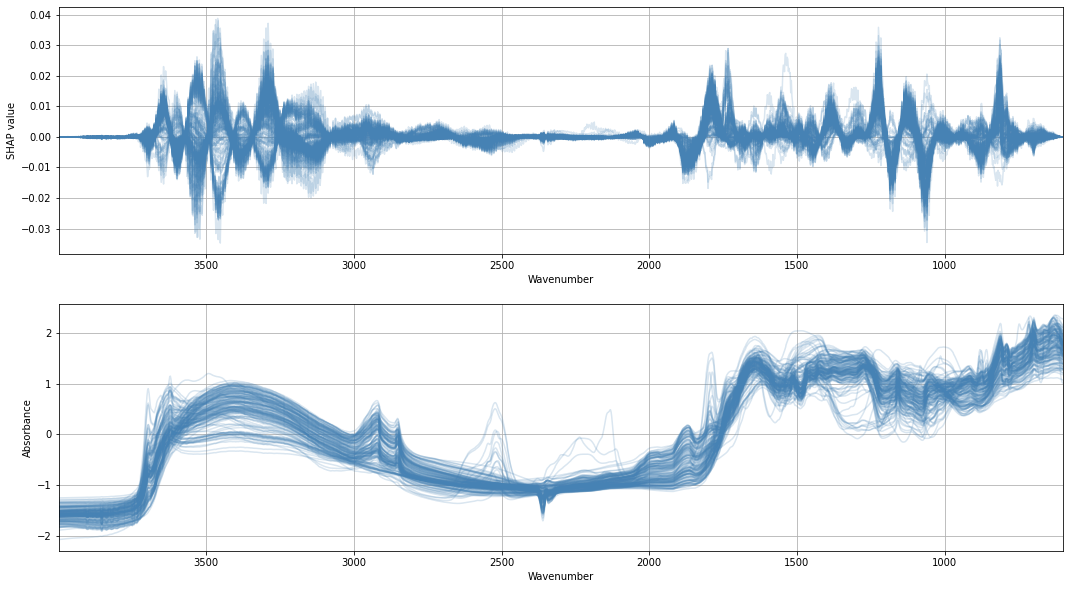

In [32]:
# Positive and low loss
plot_shap_values(X_test[np.logical_and(mask_pos, loss<0.001),:], X_names, title='Positive and low loss')

Positive and high loss
Number of samples:  100


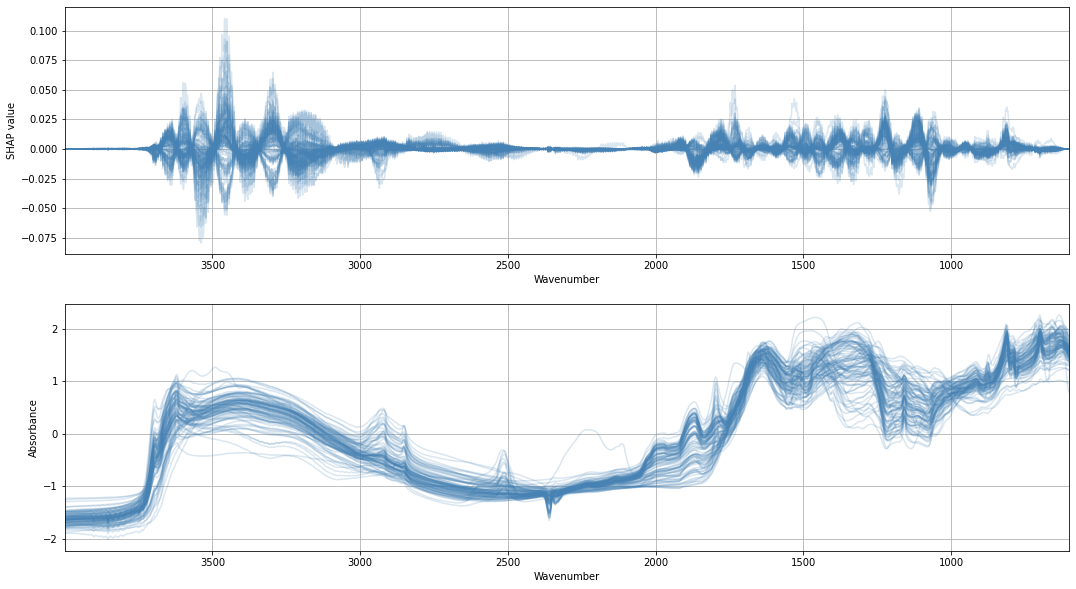

In [254]:
plot_shap_values(X_test[np.logical_and(mask_pos, loss>1.25),:], X_names, title='Positive and high loss')

Negative and low loss
Number of samples:  118


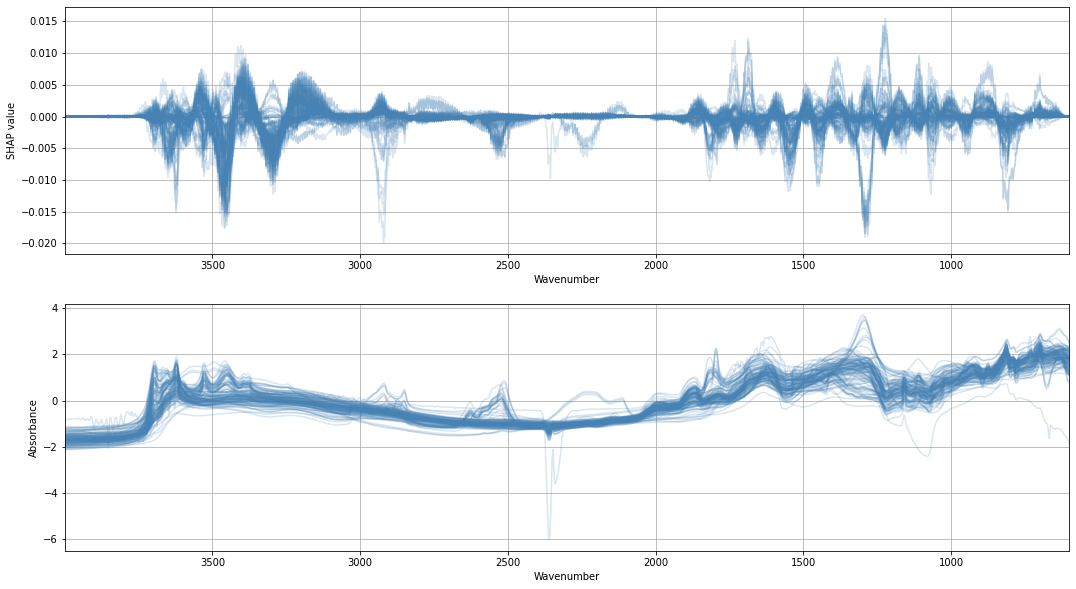

In [243]:
# Negative and low loss
plot_shap_values(X_test[np.logical_and(~mask_pos, loss<0.0003),:], X_names, title='Negative and low loss')

Negative and high loss
Number of samples:  100


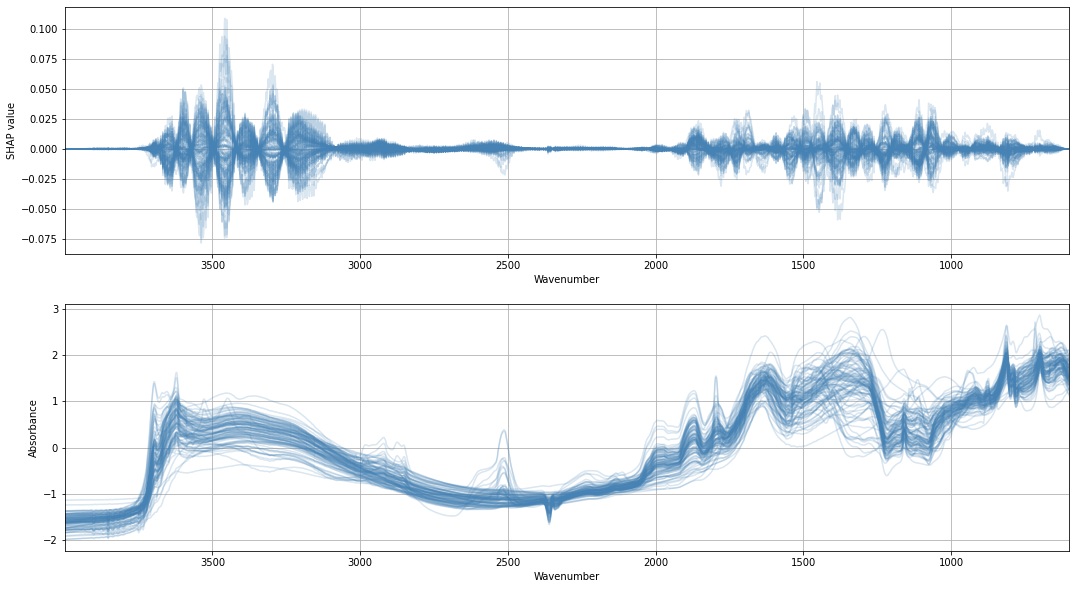

In [246]:
# Negative and high loss
plot_shap_values(X_test[np.logical_and(~mask_pos, loss>0.5),:], X_names, title='Negative and high loss')

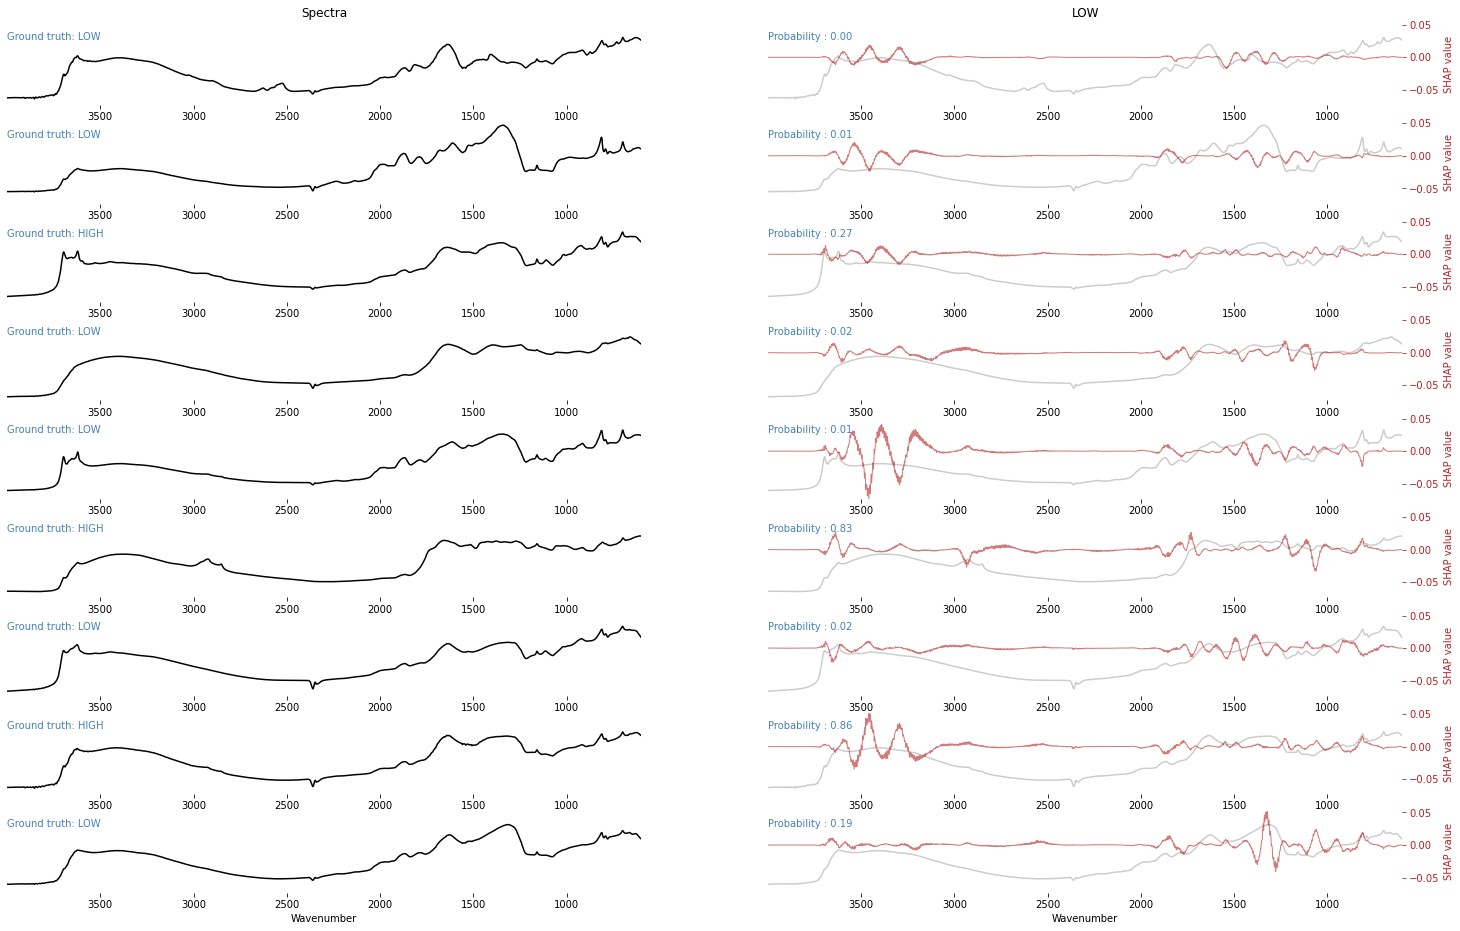

In [121]:
def plot_shap(shap_values, X, X_names,
              y_hat, y_true,
              class_label=['LOW', 'HIGH'], 
              figsize=(25, 16), accent_color='firebrick'):
  nb_spectra = X.shape[0]
  nb_classes = len(shap_values)
  min_shap, max_shap = np.min(shap_values), np.max(shap_values)
  fig, ax = plt.subplots(nb_spectra, nb_classes + 1, sharey='col', figsize=figsize)
  for row in range(nb_spectra):
    for col in range(nb_classes +1):
      # Plot spectra
      ax[row, col].set_xlim(np.max(X_names), np.min(X_names))
      alpha = 1 if col == 0 else 0.2 
      ax[row, col].plot(X_names, X[row], color='black', alpha=alpha)
      ax[row, col].spines['top'].set_visible(False)
      ax[row, col].spines['right'].set_visible(False)
      ax[row, col].spines['left'].set_visible(False)
      ax[row, col].spines['bottom'].set_visible(False)
      ax[row, col].get_yaxis().set_visible(False) 
      
      if row == 0:
        label = 'Spectra' if col == 0 else class_label[col-1]  
        ax[row, col].set_title(label)

      if row == nb_spectra - 1:
        ax[row, col].set_xlabel('Wavenumber')

      if col == 0:
          #print(y_true[row])
          ax[row, col].annotate('Ground truth: {}'.format(class_label[y_true[row]]), xy=[0, 0.8], xycoords='axes fraction', color='steelblue')

      # Plot SHAP values
      if col >= 1:
        ax_twin = ax[row, col].twinx()
        ax_twin.set_ylim(min_shap, max_shap)
        ax_twin.spines['top'].set_visible(False)
        ax_twin.spines['right'].set_visible(False)
        ax_twin.spines['left'].set_visible(False)
        ax_twin.spines['bottom'].set_visible(False)
        ax_twin.tick_params('y', colors=accent_color) 
        ax_twin.plot(X_names, shap_values[col - 1][row], color=accent_color, alpha=0.6, linewidth=1)
        if col == nb_classes:
          ax_twin.set_ylabel('SHAP value', color=accent_color)
        ax[row, col].annotate('Probability : {:.2f}'.format(y_hat[row, col - 1]), xy=[0, 0.8], xycoords='axes fraction', color='steelblue')

  
  plt.show()

plot_shap(shap_values, X_test[1:10], X_names, model.predict(X_test[1:10]), y_test[1:10])

### 8. Which threshold for low, high?

In [ ]:
def assess_thresholds(X, y, thresholds=[0.425], model_selection=None, random_state=42):
    assert np.min(thresholds) > np.min(y), 'Lower threshold should be higher than y min. value'
    assert np.max(thresholds) < np.max(y) , 'Higher threshold should be lower than y max value'

    for threshold in thresholds:
        y_b = np.where(y > threshold, 1, 0) # High is 1, Low is 0 
        X_train, X_test, y_train, y_test = train_test_split(X, y_b,stratify=y_b, 
                                                            test_size=0.2, random_state=random_state)
        model_selection.fit(X_train, y_train)
        y_train_pred = cross_val_predict(model_selection.best_estimator_, X_train, y_train, cv=5, method='decision_function')
        fpr, tpr, decision_thresholds = roc_curve(y_train, y_train_pred, drop_intermediate=True)
        opt_tpr, opt_fpr, opt_prob_threshold = optimal_roc_cutoff(tpr, fpr, decision_thresholds)
        history.append(
            {'threshold': threshold, 
             'fpr': fpr, 
             'tpr': tpr,
             'decision_thresholds': decision_thresholds, 
             'opt_tpr': opt_tpr,
             'opt_fpr': opt_fpr,
             'opt_prob_tresholds': opt_prob_threshold,
             'auc': roc_auc_score(y_train, y_train_pred), 
             'best_params': model_selection.best_params_})
    
    return history

In [ ]:
history = []

# Hyperparameter grid for Logistic Regression
co2_region = [2389,  2269]
param_grid = {'model__C': [50]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', LogisticRegression(max_iter=2000, multi_class='auto', penalty='l2'))])

grid_search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy', return_train_score=True, verbose=0)

thresholds = [i/10 for i in range(1,11)]

assess_thresholds(X_valid, y_valid[:, -1], thresholds=thresholds, model_selection=grid_search)

[{'threshold': 0.1,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.99951574, 0.99951574,
         1.        ]),
  'tpr': array([0.00000000e+00, 2.98382765e-05, 4.62493286e-03, ...,
         9.99970162e-01, 1.00000000e+00, 1.00000000e+00]),
  'decision_thresholds': array([14.1217837 , 13.1217837 ,  7.57180845, ..., -2.82453981,
         -2.8316119 , -3.35131066]),
  'opt_tpr': 0.8204332517753774,
  'opt_fpr': 0.17966101694915254,
  'opt_prob_tresholds': 0.13466679843596743,
  'auc': 0.8991550782651492,
  'best_params': {'model__C': 50}},
 {'threshold': 0.2,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.99920643, 0.99920643,
         1.        ]),
  'tpr': array([0.00000000e+00, 3.62805210e-05, 7.98171462e-03, ...,
         9.99963719e-01, 1.00000000e+00, 1.00000000e+00]),
  'decision_thresholds': array([16.31713664, 15.31713664,  6.07907289, ..., -5.56167543,
         -5.84434704, -8.60449913]),
  'opt_tpr': 0.8234589848710228,
  'opt_fpr': 0.176569784743577,
  

### 9. Error analysis

In [ ]:
# Get predictions probabilities
y_hat_prob = grid_search.best_estimator_.predict_proba(X_test)

In [ ]:
def get_mahalanobis_dist(X, n_components=20):
    pca = PCA(n_components=n_components)
    T = pca.fit_transform(TakeDerivative().fit_transform(SNV().fit_transform(X)))
    robust_cov = MinCovDet().fit(T[:, :n_components])
    return robust_cov.mahalanobis(T[:,:n_components])


In [ ]:
maha_dist = get_mahalanobis_dist(X_test, n_components=40)

In [ ]:
y_test_c = y[[np.argwhere(instances_id == i)[0].item() for i in smp_id_test], -1]

In [ ]:
# Is there any  
df_error_analysis = pd.DataFrame(np.c_[y_hat_prob[:, :], y_test, smp_id_test, y_test_c,maha_dist], 
                                 columns=['prob_low', 'prob_high', 'ground_truth', 'smp_id', 'y_continuous', 'm_dist'])

df_error_analysis['smp_id'] = df_error_analysis['smp_id'].astype('int')
df_error_analysis.head()

prob_low  prob_high  ground_truth  smp_id  y_continuous      m_dist
0  0.747794   0.252206           0.0  259578      0.272249   33.132500
1  0.692258   0.307742           0.0  106483      0.124725  823.282061
2  0.281575   0.718425           0.0  188007      0.980868   19.984470
3  0.537796   0.462204           1.0  268784      1.176460   12.467060
4  0.621498   0.378502           0.0  246983      0.848760   17.558100

count    1351.000000
mean        2.473942
std         1.848152
min         1.063780
25%         1.396139
50%         1.909578
75%         2.819663
max        18.591898
Name: y_continuous, dtype: float64

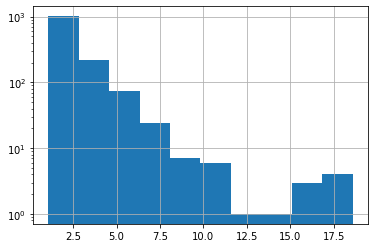

In [ ]:
# TP
mask_TP = (df_error_analysis['ground_truth'] == 1) & (df_error_analysis['prob_high'] > 0.54)
df_TP = df_error_analysis[mask_TP]

df_TP['y_continuous'].hist(log=True)
df_TP['y_continuous'].describe()

count    5429.000000
mean        0.396291
std         0.217476
min         0.120052
25%         0.220066
50%         0.342519
75%         0.522652
max         1.059469
Name: y_continuous, dtype: float64

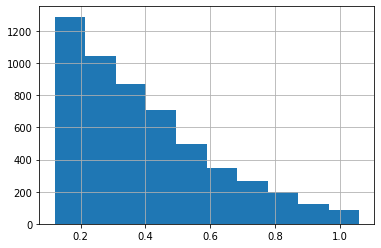

In [ ]:
# TN
mask_TN = (df_error_analysis['ground_truth'] == 0) & (df_error_analysis['prob_high'] < 0.54)
df_TN = df_error_analysis[mask_TN]

df_TN['y_continuous'].hist()
df_TN['y_continuous'].describe()

count    206.000000
mean       1.538808
std        0.623350
min        1.063670
25%        1.193499
50%        1.350522
75%        1.642722
max        5.916869
Name: y_continuous, dtype: float64

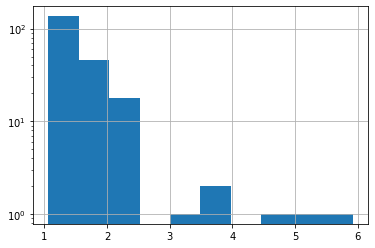

In [ ]:
# FN
mask_FN = (df_error_analysis['ground_truth'] == 1) & (df_error_analysis['prob_low'] > 0.54)
df_FN = df_error_analysis[mask_FN]

df_FN['y_continuous'].hist(log=True)
df_FN['y_continuous'].describe()

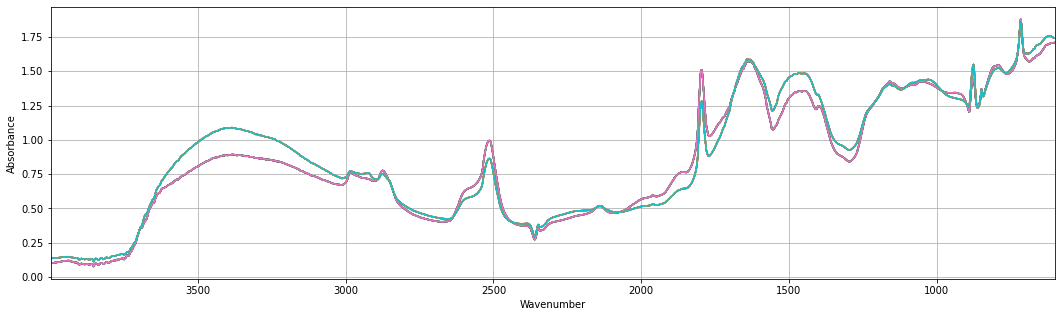

In [ ]:
df_error_analysis[(df_error_analysis['ground_truth'] == 1) & 
                  (df_error_analysis['prob_low'] > 0.54) &
                  (df_error_analysis['y_continuous'] > 5)]['smp_id'].to_numpy()

plot_spectra(X[[np.argwhere(instances_id == i)[0].item() for i in [256376, 256377]], :], X_names, sample=20)

count    1014.000000
mean        0.653730
std         0.250957
min         0.120125
25%         0.471680
50%         0.666846
75%         0.864488
max         1.061361
Name: y_continuous, dtype: float64

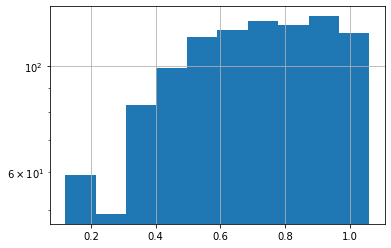

In [ ]:
# FP
mask_FP = (df_error_analysis['ground_truth'] == 0) & (df_error_analysis['prob_high'] > 0.54)
df_FP = df_error_analysis[mask_FP]

df_FP['y_continuous'].hist(log=True)
df_FP['y_continuous'].describe()

#### Assessing algo. confidence 

In [ ]:
df_error_analysis['metric'] = np.nan
df_error_analysis['prob'] = np.nan

In [ ]:
df_error_analysis.loc[mask_TP, 'metric'] = 'TP'
df_error_analysis.loc[mask_TP, 'prob'] = df_error_analysis.loc[mask_TP, 'prob_high'] 

In [ ]:
df_error_analysis.loc[mask_TN, 'metric'] = 'TN'
df_error_analysis.loc[mask_TN, 'prob'] = df_error_analysis.loc[mask_TN, 'prob_low'] 

In [ ]:
df_error_analysis.loc[mask_FN, 'metric'] = 'FN'
df_error_analysis.loc[mask_FN, 'prob'] = df_error_analysis.loc[mask_FN, 'prob_low'] 

In [ ]:
df_error_analysis.loc[mask_FP, 'metric'] = 'FP'
df_error_analysis.loc[mask_FP, 'prob'] = df_error_analysis.loc[mask_FP, 'prob_high'] 

In [ ]:
df_error_analysis.head()

prob_low  prob_high  ground_truth  ...      m_dist  metric      prob
0  0.747794   0.252206           0.0  ...   33.132500      TN  0.747794
1  0.692258   0.307742           0.0  ...  823.282061      TN  0.692258
2  0.281575   0.718425           0.0  ...   19.984470      FP  0.718425
3  0.537796   0.462204           1.0  ...   12.467060     NaN       NaN
4  0.621498   0.378502           0.0  ...   17.558100      TN  0.621498

[5 rows x 8 columns]

Text(0, 0.5, 'Probability is Positive or Negative')

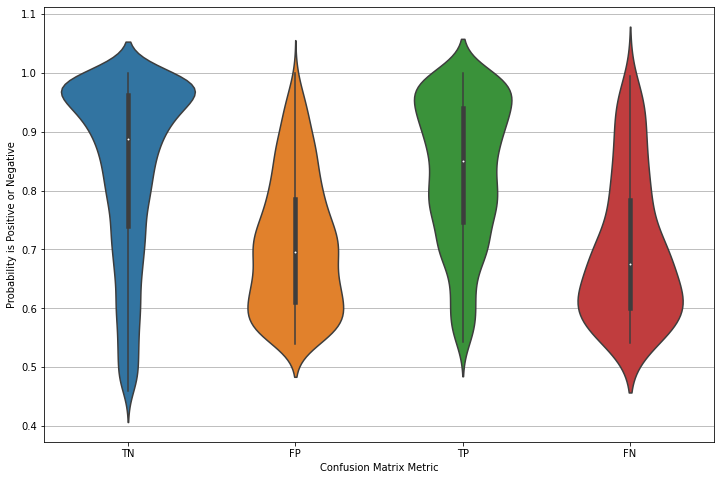

In [ ]:
# Is algo. more certain when right?
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(True, which='both')
ax.set_axisbelow(True)
sns.violinplot(x='metric', y="prob", data=df_error_analysis, ax=ax)

plt.xlabel('Confusion Matrix Metric')
plt.ylabel('Probability is Positive or Negative')

In [ ]:
np.min(df_error_analysis['m_dist'])

6.178400824665288

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Text(0, 0.5, 'Mahalanobis distance')

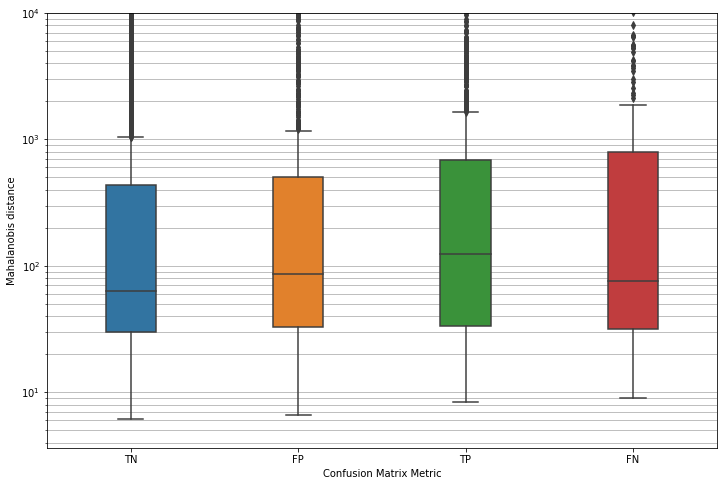

In [ ]:
# Is Mahalanobis distance greater when wrong?
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(True, which='both')
ax.set_axisbelow(True)
g = sns.boxplot(x='metric', y="m_dist", data=df_error_analysis, ax=ax, width=0.3)
g.set_yscale("log")
ax.set(ylim=(0, 10000))
plt.xlabel('Confusion Matrix Metric')
plt.ylabel('Mahalanobis distance')

#### Exploring TN, TP, ... spectral features

In [ ]:
# Encoding confusion matrix as a single vector
conf_entry = np.empty_like(mask_TN, dtype=np.int)
masks = [mask_TP, mask_FP, mask_FN, mask_TN]
for i, mask in enumerate(masks):
    conf_entry[mask] = i

In [ ]:
# Define the PCA object
n_components = 20
pca = PCA(n_components=n_components)

T = pca.fit_transform(SNV().fit_transform(X_test))

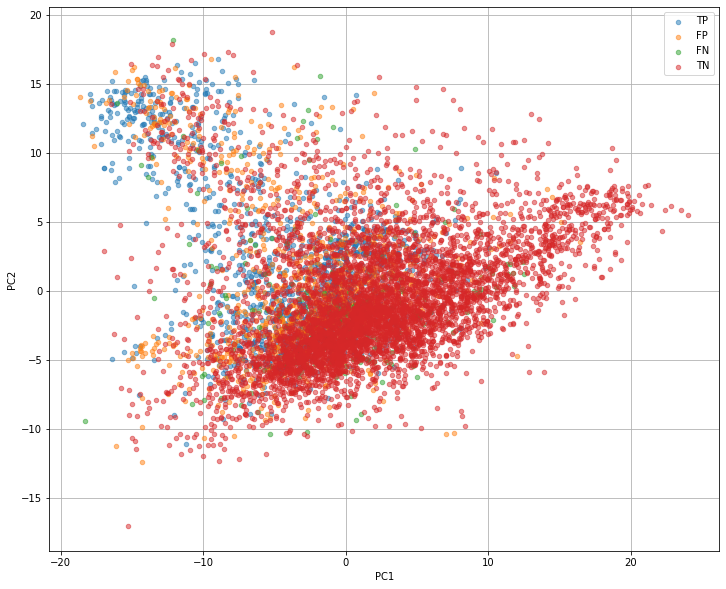

In [ ]:
# Score plot of the first 2 PC colored with confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
 
label_colors_masks = zip(['TP', 'FP', 'FN', 'TN'], 
                         ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'],
                         masks)
cpt_x, cpt_y = 0, 1
for label, color, mask in label_colors_masks:
    ax.scatter(T[mask, cpt_x], T[mask, cpt_y], c=color, label=label, edgecolors=None, s=20, alpha=0.5)
plt.xlabel('PC{}'.format(cpt_x+1))
plt.ylabel('PC{}'.format(cpt_y+1))
ax.set_axisbelow(True)
ax.grid(True, which='both')
plt.legend();

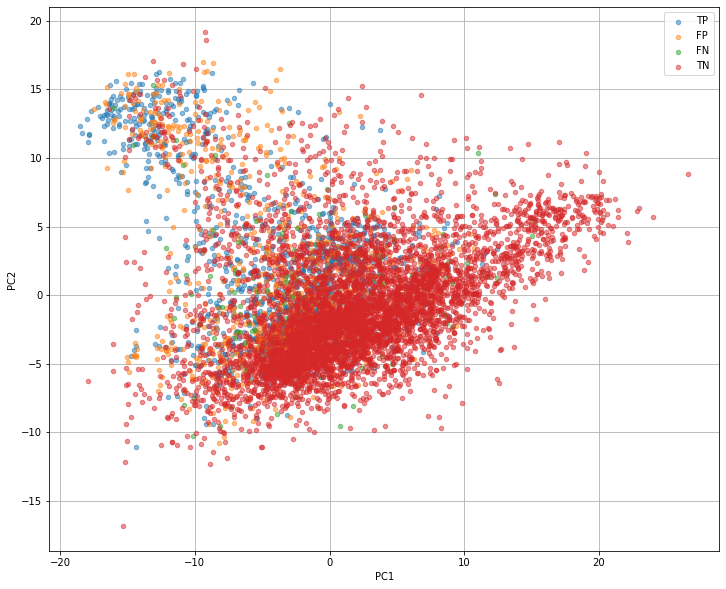

In [ ]:
# Faceted scores plot of the first 2 PC 
fig, ax = plt.subplots(figsize=(12, 10))
 
label_colors_masks = zip(['TP', 'FP', 'FN', 'TN'], 
                         ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'],
                         masks)


cpt_x, cpt_y = 0, 1
for label, color, mask in label_colors_masks:
    ax.scatter(T[mask, cpt_x], T[mask, cpt_y], c=color, label=label, edgecolors=None, s=20, alpha=0.5)
plt.xlabel('PC{}'.format(cpt_x+1))
plt.ylabel('PC{}'.format(cpt_y+1))
ax.set_axisbelow(True)
ax.grid(True, which='both')
plt.legend();

In [ ]:
labels = ['TP', 'FP', 'FN', 'TN']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
label_colors_masks = zip(labels, colors, masks)

In [ ]:
df_error_analysis['pc1'] = T[:, 0]
df_error_analysis['pc2'] = T[:, 1]


In [ ]:
df_error_analysis.head()

prob_low  prob_high  ground_truth  ...      prob        pc1        pc2
0  0.747794   0.252206           0.0  ...  0.747794  -5.794431  -4.811588
1  0.692258   0.307742           0.0  ...  0.692258 -14.226584  14.630648
2  0.281575   0.718425           0.0  ...  0.718425   0.384714  -0.168949
3  0.537796   0.462204           1.0  ...       NaN   3.349318  -0.565449
4  0.621498   0.378502           0.0  ...  0.621498   5.791968   0.814446

[5 rows x 10 columns]

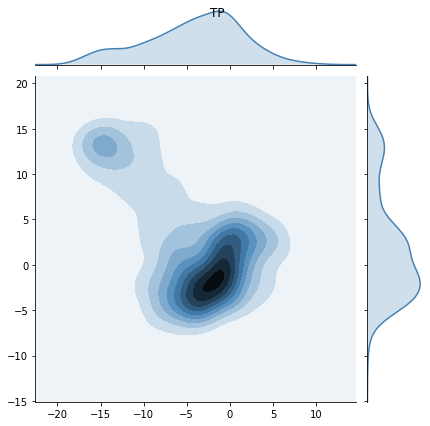

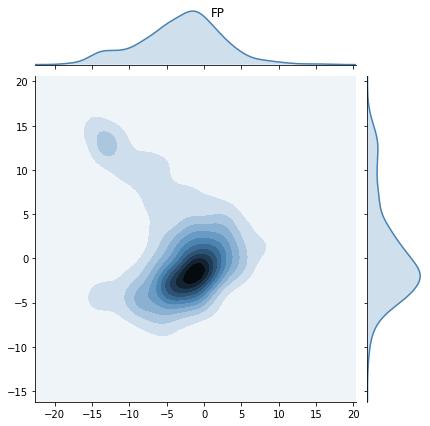

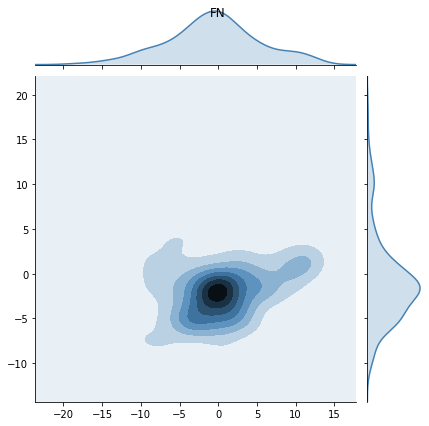

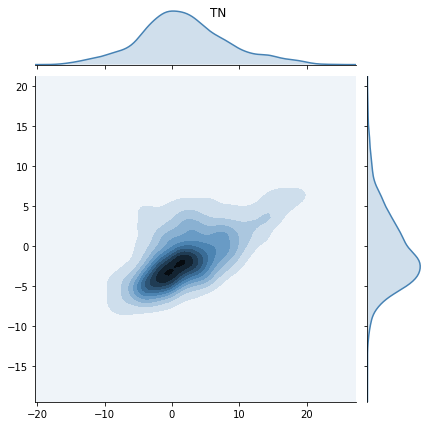

In [ ]:
for i in range(len(masks)):
    #print('PCs Scatter Plot for: {}'.format(labels[i]))
    #sns.jointplot(data=df_error_analysis, x='pc1', y='pc2', kind='kde')
    p = sns.jointplot(x=T[masks[i],0], y=T[masks[i],1], kind="kde", color='steelblue')
    p.fig.suptitle(labels[i])

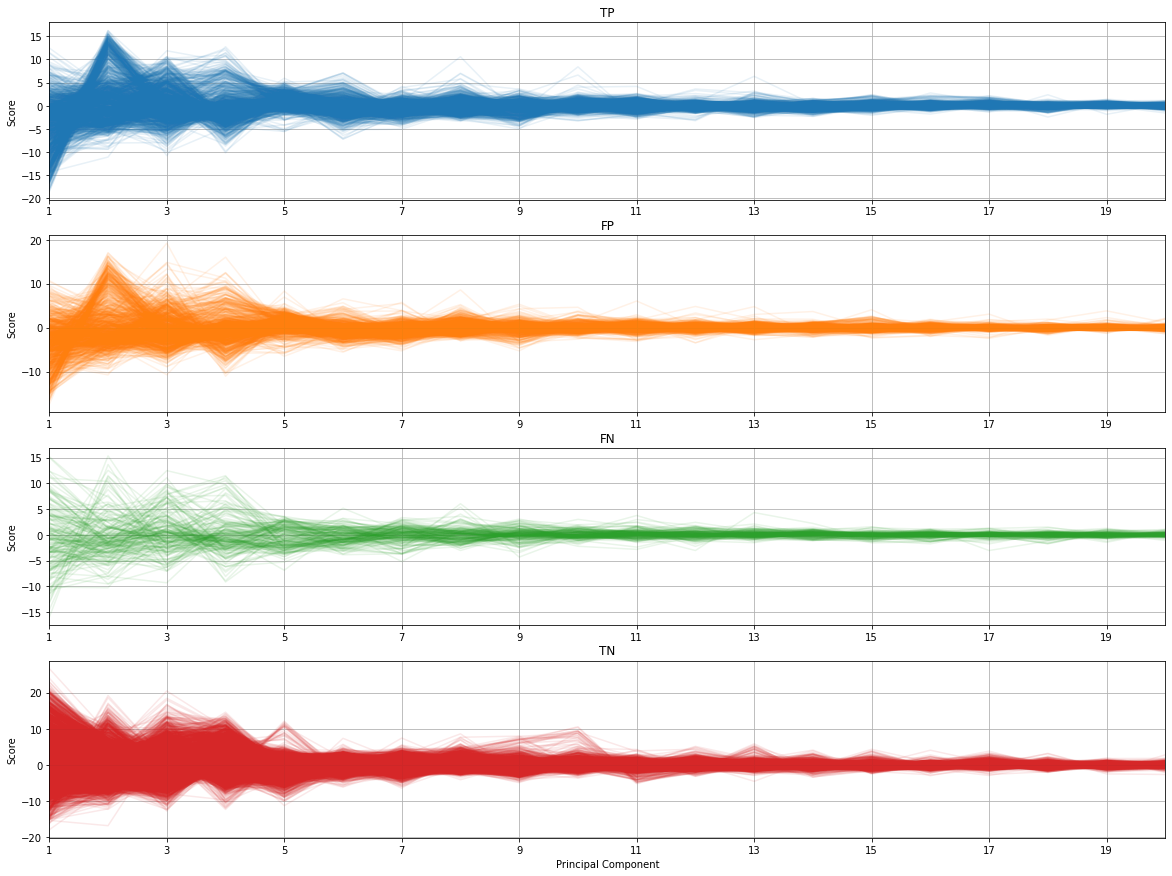

In [ ]:
# Score plots for confusion matrix
fig, ax = plt.subplots(len(labels), figsize=(20, 15))
for row in range(len(labels)):
    ax[row].plot(range(1, n_components+1), T[masks[row], :].T, c=colors[row], alpha=0.1)
    ax[row].set_axisbelow(True)
    ax[row].grid(True, which='both')
    ax[row].set_title(labels[row])
    ax[row].set_xticks(np.arange(1, 21, step=2))
    ax[row].set_ylabel('Score')
    ax[row].set_xlim(1, 20)

plt.xlabel('Principal Component');
#plt.ylabel('PC{}'.format(cpt_y+1))
#ax.set_axisbelow(True)
#plt.legend();

In [ ]:
def plot_along_wn(X, X_names, y_label='Absorbance', title='Weights', figsize=(22, 5)):   
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.xlabel('Wavenumber')
    plt.ylabel(y_label)
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.title(title)
    _ = ax.plot(X_names, X)

(8064, 20)

In [ ]:
len(masks)

4

### 9. SHAP values

In [ ]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(grid_search.best_estimator_.predict_proba, X_train[:100, :], link="logit")

In [ ]:
shap_values = explainer.shap_values(X_test[mask_TP,:][:2,:], nsamples=100)

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.112e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=9.205e-02, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 91 iterations, i.e. alpha=9.188e-02, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 93 iterations, alpha=9.187e-02, previous alpha=9.143e-02, with an active set of 24 regressors.
Regressors in active set degenerate. Dropping a regressor, after 5 ite

In [ ]:
shap_values[0].shape

(2, 1764)

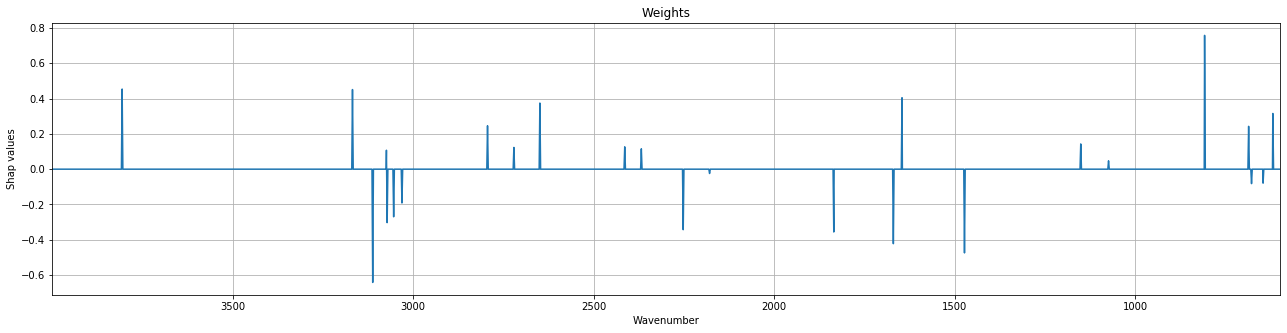

In [ ]:
plot_along_wn(shap_values[1][0], X_names, y_label='Shap values')

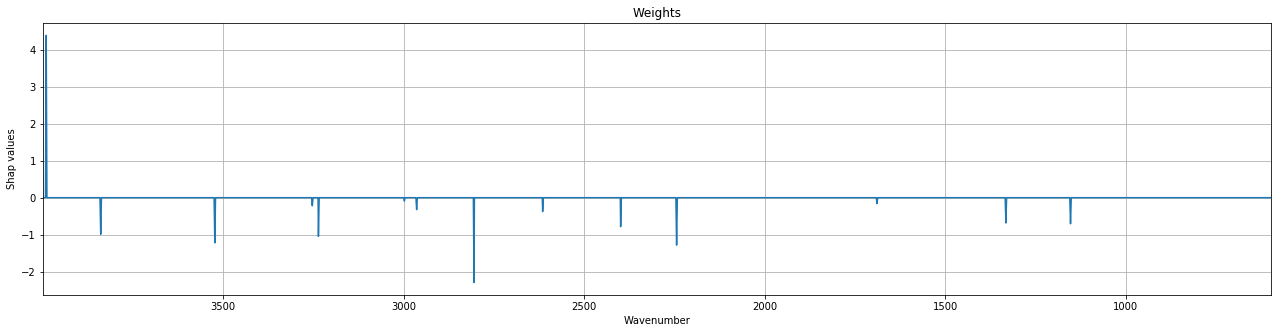

In [ ]:
plot_along_wn(shap_values[0][1], X_names, y_label='Shap values')

In [ ]:
def plot_shap(shap_values, X, X_names,
              y_hat, y_true,
              class_label=['LOW', 'HIGH'], 
              figsize=(25, 16), accent_color='firebrick'):
  nb_spectra = X.shape[0]
  nb_classes = len(shap_values)
  min_shap, max_shap = np.min(shap_values), np.max(shap_values)
  fig, ax = plt.subplots(nb_spectra, nb_classes + 1, sharey='col', figsize=figsize)
  for row in range(nb_spectra):
    for col in range(nb_classes +1):
      # Plot spectra
      ax[row, col].set_xlim(np.max(X_names), np.min(X_names))
      alpha = 1 if col == 0 else 0.2 
      ax[row, col].plot(X_names, X[row], color='black', alpha=alpha)
      ax[row, col].spines['top'].set_visible(False)
      ax[row, col].spines['right'].set_visible(False)
      ax[row, col].spines['left'].set_visible(False)
      ax[row, col].spines['bottom'].set_visible(False)
      ax[row, col].get_yaxis().set_visible(False) 
      
      if row == 0:
        label = 'Spectra' if col == 0 else class_label[col-1]  
        ax[row, col].set_title(label)

      if row == nb_spectra - 1:
        ax[row, col].set_xlabel('Wavenumber')

      if col == 0:
        ax[row, col].annotate('Ground truth: {}'.format(class_label[y_true[row]]), xy=[0, 0.8], xycoords='axes fraction', color='steelblue')

      # Plot SHAP values
      if col >= 1:
        ax_twin = ax[row, col].twinx()
        ax_twin.set_ylim(min_shap, max_shap)
        ax_twin.spines['top'].set_visible(False)
        ax_twin.spines['right'].set_visible(False)
        ax_twin.spines['left'].set_visible(False)
        ax_twin.spines['bottom'].set_visible(False)
        ax_twin.tick_params('y', colors=accent_color) 
        ax_twin.plot(X_names, shap_values[col - 1][row], color=accent_color, alpha=0.6, linewidth=1)
        if col == nb_classes:
          ax_twin.set_ylabel('SHAP value', color=accent_color)
        ax[row, col].annotate('Probability : {:.2f}'.format(y_hat[row, col - 1]), xy=[0, 0.8], xycoords='axes fraction', color='steelblue')

  
  plt.show()

In [ ]:
y_test[mask_TP][:2]

array([1, 1])

IndexError: too many indices for array

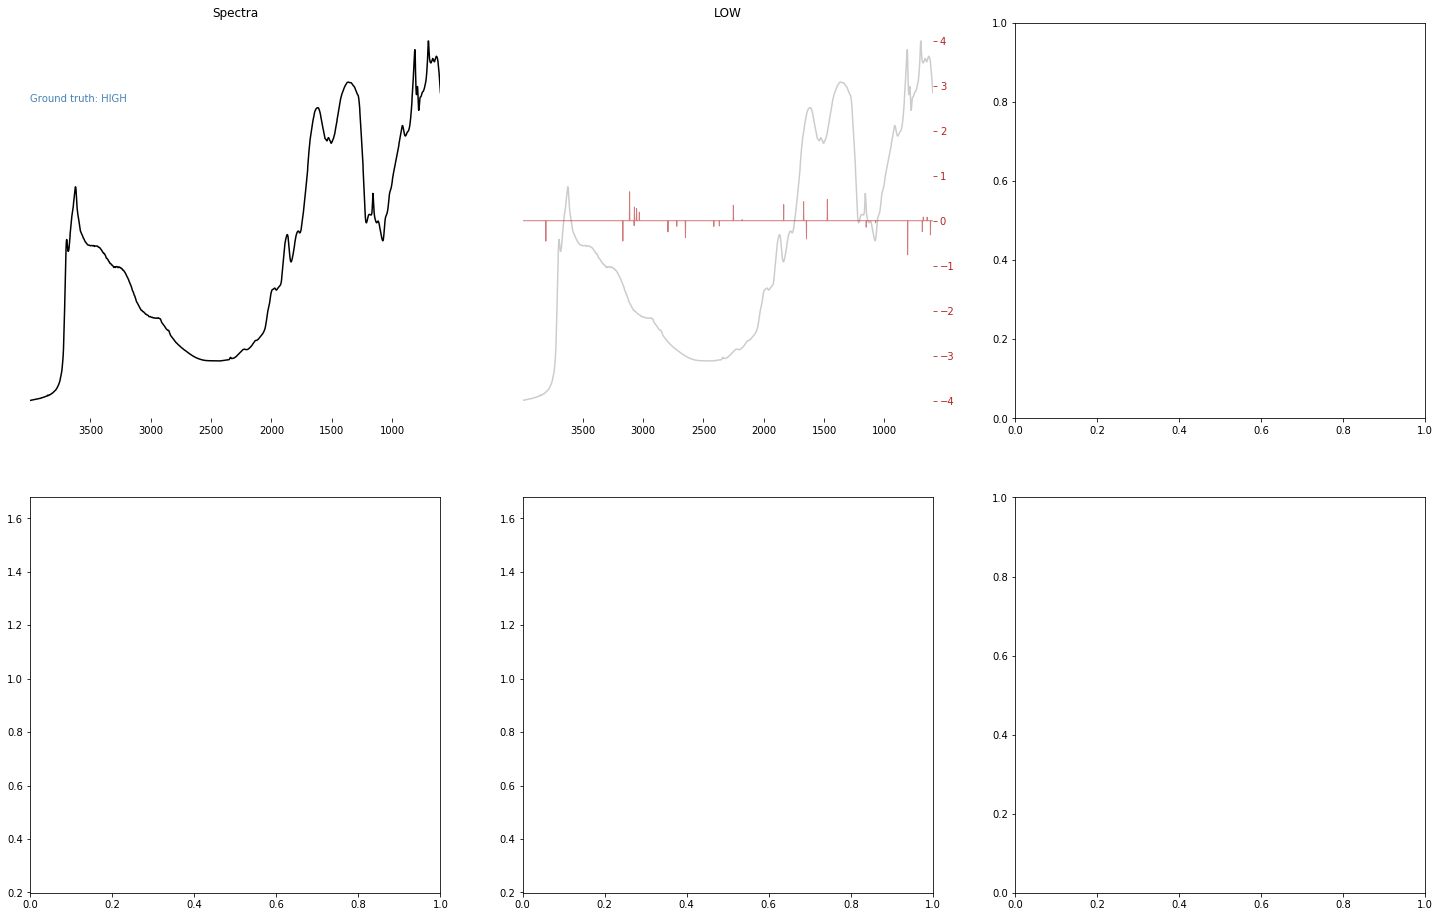

In [ ]:
X_shap_test = X_test[mask_TP,:][:2,:]

plot_shap(shap_values, 
          X_shap_test,
          X_names, 
          grid_search.best_estimator_.predict(X_shap_test), 
          y_test[mask_TP][:2])